In [1]:
from itertools import product
import numpy as np
from scipy.optimize import minimize
from scipy.special import erf, erfinv
from matplotlib import colormaps
import matplotlib.pyplot as plt

In [2]:
rmax, s, th = 100, 1, 5
phi = lambda x, s, th, rmax: rmax/2 * (1 + erf((x - th) / (np.sqrt(2) * s)))
dphi = lambda x, s, th, rmax: rmax/np.sqrt(2*np.pi) / s * np.exp(-(x - th)**2 / (2 * s**2))

In [3]:
def inv_phi(r, s, th, rmax):
    x = 2 * r / rmax - 1
    aux = erfinv(x) * np.sqrt(2) * s + th
    # if hasattr(x, '__iter__'):
    #     aux[x<-1+1e-4] = 0
    #     aux[x>1-1e-4] = 1000
    return aux

In [4]:
def local_flow(rA, rI, sig_net, ext_I, JEE, JEI, JIE, JII):
    drA = -rA + phi(JEE * rA - JEI * rI, np.sqrt(s**2 + sig_net**2), th, rmax)
    drI = -rI + phi(JIE * rA - JII * rI, s, th - ext_I, rmax)
    return np.array([drA, drI])

def jacob_eig(dphiA, dphiI, JEE, JEI, JIE, JII):
    J = np.array([[dphiA * JEE - 1, -dphiA * JEI], 
                  [dphiI * JIE, -dphiI * JII - 1]])
    return np.linalg.eig(J)

In [5]:
JEE, JEI, JIE, JII = 10, 10, 10, 4
rA = np.hstack([10**(np.arange(-10, -2.1, 1)), np.linspace(1e-1, rmax, num=500)])
rI = np.hstack([10**(np.arange(-10, -2.1, 1)), np.linspace(1e-1, rmax, num=500)])

In [6]:
def opt_func(x, sig_net, HVC, ext_I):
    rA, rI = x
    s_ = np.sqrt(s**2 + sig_net**2)
    rA_null = (JEE * rA - inv_phi(rA, s_, th - HVC, rmax)) / JEI
    rI_null = (JII * rI + inv_phi(rI, s, th - ext_I, rmax)) / JIE
    return np.sqrt((rA - rI_null)**2 + (rA_null - rI)**2)

[-0.99955424+0.00106237j -0.99955424-0.00106237j]
[ -5.4310981  -75.10595364]


[Text(0.5, 0, 'rA'), Text(0, 0.5, 'rI'), (-1.0, 30.0), (-1.0, 40.0)]

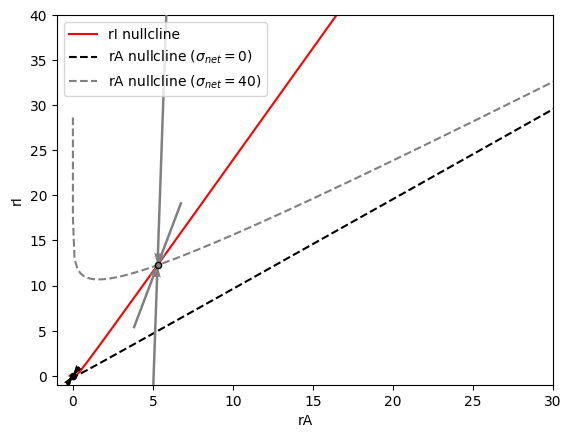

In [7]:
fig, ax = plt.subplots(1)
cmap = colormaps.get_cmap('grey')

ext_I = 0
sI, thI = s, th - ext_I
rI_null = (JII * rI + inv_phi(rI, sI, thI, rmax)) / JIE
ax.plot(rI_null, rI, ls='-', c='r', label='rI nullcline')
for i, sig in enumerate((0, 40)):
    sA = np.sqrt(s**2 + sig**2)
    HVC = 0 if sig == 0 else 10
    thA = th - HVC
    rA_null = (JEE * rA - inv_phi(rA, sA, thA, rmax)) / JEI

    color = cmap(i/2)
    ax.plot(rA, rA_null, c=color, ls='--',
            label='rA nullcline ($\sigma_{net}=%d$)' % sig)
    if i > 0:
        diff = (rA[:,None] - rI_null[None,:])**2 + (rA_null[:,None] - rI[None,:])**2
        idx = np.argwhere(diff == diff.min())
        fp = np.array([rA[idx[0][0]], rA_null[idx[0][0]]])
        fp = np.array([rI_null[idx[0][1]], rI[idx[0][1]]])
    else:
        fp = np.zeros(2)
    fp = minimize(opt_func, x0=fp, args=(sig, HVC, ext_I), 
                  tol=1e-10, method='Nelder-Mead').x

    
    dphiA = dphi(JEE * fp[0] - JEI * fp[1], sA, thA, rmax)
    dphiI = dphi(JIE * fp[0] - JII * fp[1], sI, thI, rmax)
    eigval, eigvec = jacob_eig(dphiA, dphiI, JEE, JEI, JIE, JII)
    print(eigval)
    # print(local_flow(*fp, sig, JEE, JEI, JIE, JII))
    ax.scatter(*fp, color=color, s=20, ec='k', zorder=10)
    for j in range(2):
        pv = 'tip' if np.real(eigval[j]) < 0 else 'tail'
        ax.quiver(*fp, *np.real(eigvec[:,j]), color=color, zorder=5,
                  scale=40/np.abs(eigval[j]), pivot=pv, width=0.005)
        ax.quiver(*fp, *np.real(-eigvec[:,j]), color=color, zorder=5,
                  scale=40/np.abs(eigval[j]), pivot=pv, width=0.005)
        
ax.legend(loc='upper left')
ax.set(xlabel='rA', ylabel='rI', xlim=[-1, 30], ylim=[-1, 40])